# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [44]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

lets have a look at the raw data

In [45]:
portfolio['duration'] = portfolio['duration']*24 #make duration in hours to match transaction table later
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,168,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,96,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,168,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,240,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,72,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,120,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,168,2906b810c7d4411798c6938adc9daaa5,discount,2


first lets create numerical data out of the offer_type, since it is either ```bogo```, ```discount``` or ```informational``` . Lateron we can remove the last column since being dependant of the first two when using the dataframe for training a model.

In [5]:
portfolio = pd.concat([portfolio, pd.get_dummies(portfolio.offer_type)[['bogo','discount','informational']]],axis=1)
portfolio.drop('offer_type',axis=1,inplace=True)
portfolio

,channels,difficulty,duration,id,reward,bogo,discount,informational
0,"[email, mobile, social]",10,168,ae264e3637204a6fb9bb56bc8210ddfd,10,1,0,0
1,"[web, email, mobile, social]",10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,0,0
2,"[web, email, mobile]",0,96,3f207df678b143eea3cee63160fa8bed,0,0,0,1
3,"[web, email, mobile]",5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,0,0
4,"[web, email]",20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,0,1,0
5,"[web, email, mobile, social]",7,168,2298d6c36e964ae4a3e7e9706d1fb8c2,3,0,1,0
6,"[web, email, mobile, social]",10,240,fafdcd668e3743c1bb461111dcafc2a4,2,0,1,0
7,"[email, mobile, social]",0,72,5a8bc65990b245e5a138643cd4eb9837,0,0,0,1
8,"[web, email, mobile, social]",5,120,f19421c1d4aa40978ebb69ca19b0e20d,5,1,0,0
9,"[web, email, mobile]",10,168,2906b810c7d4411798c6938adc9daaa5,2,0,1,0


lets also proceed in the same manner with the ```channels```

In [6]:
# find all unique values of chanenls 

unique_channels = list(set(portfolio.channels.sum())) #what are possible channels
unique_channels= [str(channel) for channel in unique_channels] #convert to non unicode strings


# create columns for unique values of channels and do one-hot-encoding - later we might want to reduce it by one dependant column

for channel in unique_channels:
    portfolio[channel] = portfolio['channels'].apply(lambda x: 1 if channel in x else 0)
portfolio.drop('channels',axis=1, inplace=True)

portfolio

,difficulty,duration,id,reward,bogo,discount,informational,mobile,web,email,social
0,10,168,ae264e3637204a6fb9bb56bc8210ddfd,10,1,0,0,1,0,1,1
1,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,0,0,1,1,1,1
2,0,96,3f207df678b143eea3cee63160fa8bed,0,0,0,1,1,1,1,0
3,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,0,0,1,1,1,0
4,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,0,1,0,0,1,1,0
5,7,168,2298d6c36e964ae4a3e7e9706d1fb8c2,3,0,1,0,1,1,1,1
6,10,240,fafdcd668e3743c1bb461111dcafc2a4,2,0,1,0,1,1,1,1
7,0,72,5a8bc65990b245e5a138643cd4eb9837,0,0,0,1,1,0,1,1
8,5,120,f19421c1d4aa40978ebb69ca19b0e20d,5,1,0,0,1,1,1,1
9,10,168,2906b810c7d4411798c6938adc9daaa5,2,0,1,0,1,1,1,0


In [7]:
portfolio.set_index('id',inplace=True)

In [8]:
portfolio

,difficulty,duration,reward,bogo,discount,informational,mobile,web,email,social
id,,,,,,,,,,
ae264e3637204a6fb9bb56bc8210ddfd,10,168,10,1,0,0,1,0,1,1
4d5c57ea9a6940dd891ad53e9dbe8da0,10,120,10,1,0,0,1,1,1,1
3f207df678b143eea3cee63160fa8bed,0,96,0,0,0,1,1,1,1,0
9b98b8c7a33c4b65b9aebfe6a799e6d9,5,168,5,1,0,0,1,1,1,0
0b1e1539f2cc45b7b9fa7c272da2e1d7,20,240,5,0,1,0,0,1,1,0
2298d6c36e964ae4a3e7e9706d1fb8c2,7,168,3,0,1,0,1,1,1,1
fafdcd668e3743c1bb461111dcafc2a4,10,240,2,0,1,0,1,1,1,1
5a8bc65990b245e5a138643cd4eb9837,0,72,0,0,0,1,1,0,1,1
f19421c1d4aa40978ebb69ca19b0e20d,5,120,5,1,0,0,1,1,1,1


Lets proceed with the next dataframe - profile  
here we need to make gender as separate columns and clean regarding age and income

In [9]:
profile.head(5)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [10]:
profile.id = profile.id.apply(str) #convert to non unicode strings

In [11]:
len(profile[profile.age==118])

2175

In [12]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


gender and income seem to have a lot of blank values, this might be worth looking at regarding features. maybe people who do not like to give gender or income have certain tendencies. obviously age==118 correlates with gender=None and Income None

lets split became_member_on into year,month,day columns

In [13]:
def int_date_to_YMD(integer_date_YMD):
    date_string = str(integer_date_YMD)
    return date_string[:4], date_string[4:6], date_string[6:]

In [14]:
profile['member_year'] = profile['became_member_on'].apply(lambda x:int_date_to_YMD(x)[0])
profile['member_month'] = profile['became_member_on'].apply(lambda x:int_date_to_YMD(x)[1])
profile['member_day'] = profile['became_member_on'].apply(lambda x:int_date_to_YMD(x)[2])
profile.drop('became_member_on',axis=1,inplace=True)

In [15]:
profile.describe()

,age,income
count,17000.000000,14825.000000
mean,62.531412,65404.991568
std,26.738580,21598.299410
min,18.000000,30000.000000
25%,45.000000,49000.000000
50%,58.000000,64000.000000
75%,73.000000,80000.000000
max,118.000000,120000.000000


maximum and average seem to tend a bit high, something worth looking at in a distribution

(array([1308., 1438., 2054., 3383., 3257., 2031.,  966.,  361.,   27.,
        2175.]),
 array([ 18.,  28.,  38.,  48.,  58.,  68.,  78.,  88.,  98., 108., 118.]),
 <a list of 10 Patch objects>)

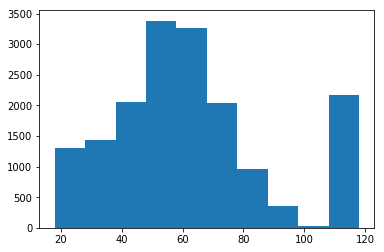

In [16]:
plt.hist(profile.age)

the average of age looks quite high for starbucks customers and the max age is probably outliers which need to be taken care of in either removing or guessing whether they substitute some other value.
first approach lets remove 118

In [17]:
profile = profile[profile.age!=118]

lets convert the male/female/other entries into columns

In [18]:
profile = pd.concat([profile, pd.get_dummies(profile.gender)[['F','M']]],axis=1)
profile.drop('gender',axis=1,inplace=True)

In [19]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 8 columns):
age             14825 non-null int64
id              14825 non-null object
income          14825 non-null float64
member_year     14825 non-null object
member_month    14825 non-null object
member_day      14825 non-null object
F               14825 non-null uint8
M               14825 non-null uint8
dtypes: float64(1), int64(1), object(4), uint8(2)
memory usage: 839.7+ KB


checking for double ids in dataset - obviously none

In [20]:
len(profile.id.unique())

14825

(array([1731., 1707., 2234., 2210., 2345., 1435., 1215.,  990.,  498.,
         460.]),
 array([ 30000.,  39000.,  48000.,  57000.,  66000.,  75000.,  84000.,
         93000., 102000., 111000., 120000.]),
 <a list of 10 Patch objects>)

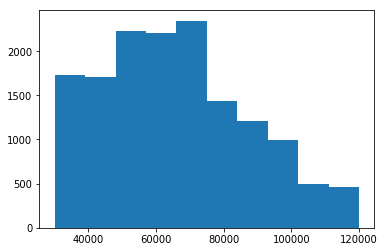

In [21]:
plt.hist(profile.dropna()['income'])

now a look onto transcript

In [22]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [23]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{u'offer id': u'9b98b8c7a33c4b65b9aebfe6a799e6...
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{u'offer id': u'0b1e1539f2cc45b7b9fa7c272da2e1...
2,offer received,e2127556f4f64592b11af22de27a7932,0,{u'offer id': u'2906b810c7d4411798c6938adc9daa...
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{u'offer id': u'fafdcd668e3743c1bb461111dcafc2...
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{u'offer id': u'4d5c57ea9a6940dd891ad53e9dbe8d...


In [24]:
[str(item) for item in list(transcript.event.unique())] #look at the unique non unicode strings

['offer received', 'offer viewed', 'transaction', 'offer completed']

create separate columns for offer and amount

In [25]:
transcript['offer id'] = transcript.value.apply(lambda x: x.values()[0] if str(x.keys()[0])==u'offer id' else None)
transcript['amount'] = transcript.value.apply(lambda x: x.values()[0] if (x.keys()[0])==u'amount' else None)
transcript.drop('value',axis=1,inplace=True)

create columns for events

In [26]:
transcript.head()

,event,person,time,offer id,amount
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [27]:
transcript = pd.concat([transcript, pd.get_dummies(transcript.event)[['offer received', 'offer viewed', 'transaction', 'offer completed']]],axis=1)
transcript.drop('event',axis=1,inplace=True)

In [28]:
transcript.head(10)

,person,time,offer id,amount,offer received,offer viewed,transaction,offer completed
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,1,0,0,0
1,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,1,0,0,0
2,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN,1,0,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,1,0,0,0
4,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,1,0,0,0
5,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,1,0,0,0
6,c4863c7985cf408faee930f111475da3,0,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,1,0,0,0
7,2eeac8d8feae4a8cad5a6af0499a211d,0,3f207df678b143eea3cee63160fa8bed,NaN,1,0,0,0
8,aa4862eba776480b8bb9c68455b8c2e1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,1,0,0,0
9,31dda685af34476cad5bc968bdb01c53,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,1,0,0,0


taking a look into the person with the most received offers to get an idea on how the advertising works

In [29]:
multi_order = transcript.groupby('person').count().sort_values('offer received',ascending=False)['offer received'].head()
multi_order

person
94de646f7b6041228ca7dec82adb97d2    51
8dbfa485249f409aa223a2130f40634a    49
5e60c6aa3b834e44b822ea43a3efea26    48
d0a80415b84c4df4908b8403b19765e3    48
79d9d4f86aca4bed9290350fb43817c2    48
Name: offer received, dtype: int64

In [30]:
example_customer = multi_order.index[0]

In [31]:
joined_transcript = transcript.join(portfolio,on='offer id')

In [32]:
joined_transcript[joined_transcript.person==example_customer].head(4)

,person,time,offer id,amount,offer received,offer viewed,transaction,offer completed,difficulty,duration,reward,bogo,discount,informational,mobile,web,email,social
2276,94de646f7b6041228ca7dec82adb97d2,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,1,0,0,0,5.0,120.0,5.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
16010,94de646f7b6041228ca7dec82adb97d2,6,f19421c1d4aa40978ebb69ca19b0e20d,NaN,0,1,0,0,5.0,120.0,5.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
24531,94de646f7b6041228ca7dec82adb97d2,30,None,7.41,0,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24532,94de646f7b6041228ca7dec82adb97d2,30,None,NaN,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


merge transcript data with portfolio data

## KPI s for person
Lets first grab a list of features that come to mind when wanting to analyze the customers behvaiour. 

- count offers received
- count offers viewed
- count transactions
- count offers completed
- total ammount spent
- view_ratio
- transaction_ratio
- completeness_ratio
- ammount spent during offer A
- ammount spent outside offer
- time being customer



In [33]:
part = joined_transcript[['person','time','offer id','offer received','offer viewed','transaction','offer completed','amount','duration']]
part = part[part.person==example_customer]

provide a general overview on what is the high level ratios of how offers work. this does not yet look into the completenesses of an offers 'walk' from offer received -> viewed ->transaction done -> completed. this will be performed separatedly

In [34]:
general_offer_behaviour = part.groupby(['person']).sum()
general_offer_behaviour['view_ratio'] = general_offer_behaviour['offer viewed']/general_offer_behaviour['offer received']
general_offer_behaviour['transaction_ratio'] = general_offer_behaviour['transaction']/general_offer_behaviour['offer received']
general_offer_behaviour['completness_ratio'] = general_offer_behaviour['offer completed']/general_offer_behaviour['offer received']
general_offer_behaviour.head(10)

,time,offer received,offer viewed,transaction,offer completed,amount,duration,view_ratio,transaction_ratio,completness_ratio
person,,,,,,,,,,
94de646f7b6041228ca7dec82adb97d2,20586,6,5,35,5,90.23,1872.0,0.833333,5.833333,0.833333


In [36]:
current_offer = None
offer_received = None
offer_viewed = None
offer_transaction = None
offer_completed = None
offer_list = []
reference = []
start_time = None
viewed_time = None
completed_time = None
start_time_list = []
offer_viewed_list=[]
offer_completed_time = []

for row in part.iterrows():
    if row[1]['offer received'] == 1:
        current_offer = row[1]['offer id']
        start_time = row[1]['time']
        completed_time = None
        viewed_time = None
    if row[1]['offer viewed'] == 1:
        viewed_time = row[1]['time']
    if row[1]['offer completed'] == 1:
        completed_time = row[1]['time']
        viewed_time = None
    
    
    offer_list.append(current_offer)
    start_time_list.append(start_time)
    offer_viewed_list.append(viewed_time)
    offer_completed_time.append(completed_time)
    reference = list(map(lambda x, y: str(x)+ '_' +str(y), offer_list, start_time_list))
    
part['reference offer'] = reference
part['offer completed time'] = offer_completed_time
part['offer view time'] = offer_viewed_list
part['offer active'] = (part['time'] > part['offer completed time'])
part['view active'] = ~(part['offer view time'] > part['offer completed time'])

        

In [37]:
current_offer = None
offer_received = None
offer_viewed = None
offer_transaction = None
offer_completed = None
offer_list = []
reference = []
start_time = None
viewed_time = None
completed_time = None
start_time_list = []
offer_viewed_list=[]
offer_completed_time = []

for row in part.iterrows():
    if row[1]['offer received'] == 1:
        current_offer = row[1]['offer id']
        start_time = row[1]['time']
        completed_time = None
        viewed_time = None
    if row[1]['offer viewed'] == 1:
        viewed_time = row[1]['time']
    if row[1]['offer completed'] == 1:
        completed_time = row[1]['time']
        viewed_time = None
    
    
    offer_list.append(current_offer)
    start_time_list.append(start_time)
    offer_viewed_list.append(viewed_time)
    offer_completed_time.append(completed_time)
    reference = list(map(lambda x, y: str(x)+ '_' +str(y), offer_list, start_time_list))
    
part['reference offer'] = reference
part['start_time'] = start_time_list
part['offer completed time'] = offer_completed_time
part['offer view time'] = offer_viewed_list
part['offer active'] = ~(part['time'] > part['offer completed time'])
part['view active'] = (part['time'] > part['offer view time'])


In [43]:
transcript.columns

Index([         u'person',            u'time',        u'offer id',
                u'amount',  u'offer received',    u'offer viewed',
           u'transaction', u'offer completed'],
      dtype='object')

In [ ]:
columns=['person','offer id','time']
times_df = pd.merge(transcript[''])

In [38]:
part.head(35)

,person,time,offer id,offer received,offer viewed,transaction,offer completed,amount,duration,reference offer,offer completed time,offer view time,offer active,view active,start_time
2276,94de646f7b6041228ca7dec82adb97d2,0,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0,0,NaN,120.0,f19421c1d4aa40978ebb69ca19b0e20d_0,NaN,NaN,True,False,0
16010,94de646f7b6041228ca7dec82adb97d2,6,f19421c1d4aa40978ebb69ca19b0e20d,0,1,0,0,NaN,120.0,f19421c1d4aa40978ebb69ca19b0e20d_0,NaN,6.0,True,False,0
24531,94de646f7b6041228ca7dec82adb97d2,30,None,0,0,1,0,7.41,NaN,f19421c1d4aa40978ebb69ca19b0e20d_0,NaN,6.0,True,True,0
24532,94de646f7b6041228ca7dec82adb97d2,30,None,0,0,0,1,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d_0,30.0,NaN,True,False,0
42252,94de646f7b6041228ca7dec82adb97d2,102,None,0,0,1,0,1.47,NaN,f19421c1d4aa40978ebb69ca19b0e20d_0,30.0,NaN,False,False,0
55475,94de646f7b6041228ca7dec82adb97d2,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,0,NaN,168.0,9b98b8c7a33c4b65b9aebfe6a799e6d9_168,NaN,NaN,True,False,168
75256,94de646f7b6041228ca7dec82adb97d2,186,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0,NaN,168.0,9b98b8c7a33c4b65b9aebfe6a799e6d9_168,NaN,186.0,True,False,168
77624,94de646f7b6041228ca7dec82adb97d2,192,None,0,0,1,0,2.62,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9_168,NaN,186.0,True,True,168
81725,94de646f7b6041228ca7dec82adb97d2,204,None,0,0,1,0,0.59,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9_168,NaN,186.0,True,True,168
93913,94de646f7b6041228ca7dec82adb97d2,246,None,0,0,1,0,2.28,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9_168,NaN,186.0,True,True,168


In [39]:
# offer received
only_offers_received = part[part['offer received']==1]
only_offers_received

,person,time,offer id,offer received,offer viewed,transaction,offer completed,amount,duration,reference offer,offer completed time,offer view time,offer active,view active,start_time
2276,94de646f7b6041228ca7dec82adb97d2,0,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0,0,NaN,120.0,f19421c1d4aa40978ebb69ca19b0e20d_0,NaN,NaN,True,False,0
55475,94de646f7b6041228ca7dec82adb97d2,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,0,NaN,168.0,9b98b8c7a33c4b65b9aebfe6a799e6d9_168,NaN,NaN,True,False,168
113102,94de646f7b6041228ca7dec82adb97d2,336,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,0,NaN,240.0,0b1e1539f2cc45b7b9fa7c272da2e1d7_336,NaN,NaN,True,False,336
152891,94de646f7b6041228ca7dec82adb97d2,408,fafdcd668e3743c1bb461111dcafc2a4,1,0,0,0,NaN,240.0,fafdcd668e3743c1bb461111dcafc2a4_408,NaN,NaN,True,False,408
203846,94de646f7b6041228ca7dec82adb97d2,504,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,0,NaN,168.0,9b98b8c7a33c4b65b9aebfe6a799e6d9_504,NaN,NaN,True,False,504
247375,94de646f7b6041228ca7dec82adb97d2,576,4d5c57ea9a6940dd891ad53e9dbe8da0,1,0,0,0,NaN,120.0,4d5c57ea9a6940dd891ad53e9dbe8da0_576,NaN,NaN,True,False,576


In [40]:
# transactions during duration
for row in only_offers_received.iterrows():
    start_time = row[1]['time']
    end_time = start_time + row[1]['duration']
    print(row[1]['offer id'],
          (part[(part['time']>=start_time) & (part['time']<end_time) & part['transaction']==1])['amount'].sum())

(u'f19421c1d4aa40978ebb69ca19b0e20d', 8.88)
(u'9b98b8c7a33c4b65b9aebfe6a799e6d9', 31.24)
(u'0b1e1539f2cc45b7b9fa7c272da2e1d7', 24.65)
(u'fafdcd668e3743c1bb461111dcafc2a4', 40.91)
(u'9b98b8c7a33c4b65b9aebfe6a799e6d9', 22.44)
(u'4d5c57ea9a6940dd891ad53e9dbe8da0', 19.599999999999998)


In [41]:
part[['person','offer active','amount']].groupby(['person','offer active'],).sum()

amount
person                           offer active        
94de646f7b6041228ca7dec82adb97d2 False          40.97
                                 True           49.26

In [42]:
part.to_excel('part.xlsx')

In [ ]:
part[part['offer id']=='4d5c57ea9a6940dd891ad53e9dbe8da0']

In [ ]:
part[part['offer active']==False]

In [ ]:
part[['person','offer active','view active','amount']].groupby(['person','offer active','view active'],).sum()

In [ ]:
true_offers = part[part['offer active']==True]
true_offers.head(20)

In [ ]:
walks = true_offers.drop_duplicates(subset=['offer received','offer viewed','transaction','offer completed','reference offer'],keep='first')
walks

In [ ]:
walks['reference offer'].value_counts() ==4

In [ ]:
part['time'][:5]

In [ ]:
part['offer completed time'][:5]

In [ ]:
joined_transcript[['person','offer id','time']].groupby(['person','offer id']).count()

next steps
- check in which cases one person follows the process for one offer as follows: offer received-viewd-transaction-completed
- is it possible that this shuffles?